# Neural ODE control of $\dot{x}=Ax+Bu$

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

Define time horizon, initial condition, and target state.

In [4]:
T = 1
true_x0 = torch.tensor([1.0,0.5])
t = torch.linspace(0., T, 40)
target_x = torch.tensor([0.0,0.0])
A=torch.tensor([[1.0,0.0],[1.0,0.0]])
B = torch.tensor([1.0,0.0])

Define neural ODE with control term.

In [5]:
class ODE_func(nn.Module):

    def __init__(self):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1,6),
            nn.ELU(),
            nn.Linear(6,6),
            nn.ELU(),
            nn.Linear(6,1)
        )
        
    def forward(self, t, y):
        return torch.matmul(A,y)+B*self.net(torch.tensor([float(t)]))

Solve control problem.

In [6]:
func = ODE_func()

optimizer = optim.Adam(func.parameters(), lr=0.02)

best_model = func.net
loss_new = 1e9

for itr in range(1, 200):

    optimizer.zero_grad()
    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = ((pred_x[-1] - target_x)**2).sum()
    loss.backward()
    optimizer.step()

    if loss < loss_new:
        best_model = func.net
        loss_new = loss
      
    if itr % 20 == 0:
        with torch.no_grad():
            pred_x = odeint(func, true_x0, t, method='dopri5')
            loss = 0.5*torch.mean(pred_x[-1] - target_x)**2
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    itr += 1

Iter 0020 | Total Loss 0.004524
Iter 0040 | Total Loss 0.013732
Iter 0060 | Total Loss 0.047947
Iter 0080 | Total Loss 0.042389
Iter 0100 | Total Loss 0.035601
Iter 0120 | Total Loss 0.026137
Iter 0140 | Total Loss 0.013659
Iter 0160 | Total Loss 0.002902
Iter 0180 | Total Loss 0.000009


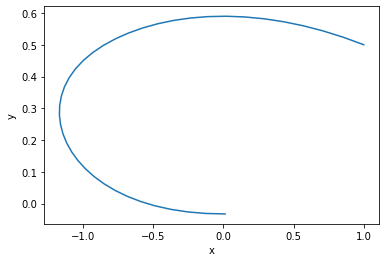

In [8]:
plt.figure()
plt.plot(pred_x.detach().numpy()[:,0],pred_x.detach().numpy()[:,1])
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.show()